In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import seaborn as sns
sns.set(font_scale=1.2, context="paper", style="ticks")
sns.set_palette("viridis")

import mysql.connector as mariadb
from astropy.time import Time

from scipy.stats import binned_statistic_2d

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("../..")

In [2]:
import thor

In [3]:
DPI = 600
SAVE_DIR = "plots/"
FORMAT = "png"

### Algorithm

In [4]:
sim_orb = {
    "a: 1.5 [AU], e: 0 [deg], i: 0 [deg]": [1.5, 0, 0, 0, 0, 0],
    "a: 2.0 [AU], e: 0 [deg], i: 0 [deg]": [2, 0, 0, 0, 0, 0],
    "a: 2.5 [AU], e: 0 [deg], i: 0 [deg]": [2.5, 0, 0, 0, 0, 0],
    "a: 1.5 [AU], e: 0 [deg], i: 20 [deg]": [1.5, 0, np.radians(20), 0, 0, 0],
    "a: 2.0 [AU], e: 0 [deg], i: 20 [deg]": [2.0, 0, np.radians(20), 0, 0, 0],
    "a: 2.5 [AU], e: 0 [deg], i: 20 [deg]": [2.5, 0, np.radians(20), 0, 0, 0],
    "a: 1.5 [AU], e: 0.3 [deg], i: 20 [deg]": [1.5, 0.3, np.radians(20), 0, 0, 0],
    "a: 2.0 [AU], e: 0.3 [deg], i: 20 [deg]": [2.0, 0.3, np.radians(20), 0, 0, 0],
    "a: 2.5 [AU], e: 0.3 [deg], i: 20 [deg]": [2.5, 0.3, np.radians(20), 0, 0, 0],
}


In [ ]:
current_epoch = 58563.04 # vernal equinox in UK ish (helps with defining a-e-i), observatory set to Greenwich
current_epoch = 58563.04 + 10
num_nights = 20
night_step = 1
new_epoch = np.arange(current_epoch, current_epoch + num_nights + 1, night_step)
ephs = []
for i, (n, o) in enumerate(sim_orb.items()):
    print(n)
    eph = thor.propagateTestParticle(#orbit_from_cat[["a_au", "e", "i_rad", "ascNode_rad", "argPeri_rad", "meanAnom_rad"]].values[0], 
                                     o,
                                     current_epoch, 
                                     new_epoch, 
                                     observatoryCode="000",
                                     mjdScale="UTC",
                                     elementType="keplerian")
    eph["designation"] = [n for _ in range(len(eph))]
    eph["night"] = np.arange(1, len(eph) + 1)
    ephs.append(eph)
    
ephs = pd.concat(ephs)
ephs.sort_values(by=["mjd", "designation"], inplace=True)
ephs.rename(columns={"mjd": "exp_mjd"}, inplace=True)
ephs["obsId"] = np.arange(0, len(ephs))


a: 1.5 [AU], e: 0 [deg], i: 0 [deg]
a: 2.0 [AU], e: 0 [deg], i: 0 [deg]
a: 2.5 [AU], e: 0 [deg], i: 0 [deg]
a: 1.5 [AU], e: 0 [deg], i: 20 [deg]
a: 2.0 [AU], e: 0 [deg], i: 20 [deg]
a: 2.5 [AU], e: 0 [deg], i: 20 [deg]
a: 1.5 [AU], e: 0.3 [deg], i: 20 [deg]
a: 2.0 [AU], e: 0.3 [deg], i: 20 [deg]
a: 2.5 [AU], e: 0.3 [deg], i: 20 [deg]


In [ ]:
print(sim_orb.keys())

dict_keys(['a: 1.5 [AU], e: 0 [deg], i: 0 [deg]', 'a: 2.0 [AU], e: 0 [deg], i: 0 [deg]', 'a: 2.5 [AU], e: 0 [deg], i: 0 [deg]', 'a: 1.5 [AU], e: 0 [deg], i: 20 [deg]', 'a: 2.0 [AU], e: 0 [deg], i: 20 [deg]', 'a: 2.5 [AU], e: 0 [deg], i: 20 [deg]', 'a: 1.5 [AU], e: 0.3 [deg], i: 20 [deg]', 'a: 2.0 [AU], e: 0.3 [deg], i: 20 [deg]', 'a: 2.5 [AU], e: 0.3 [deg], i: 20 [deg]'])


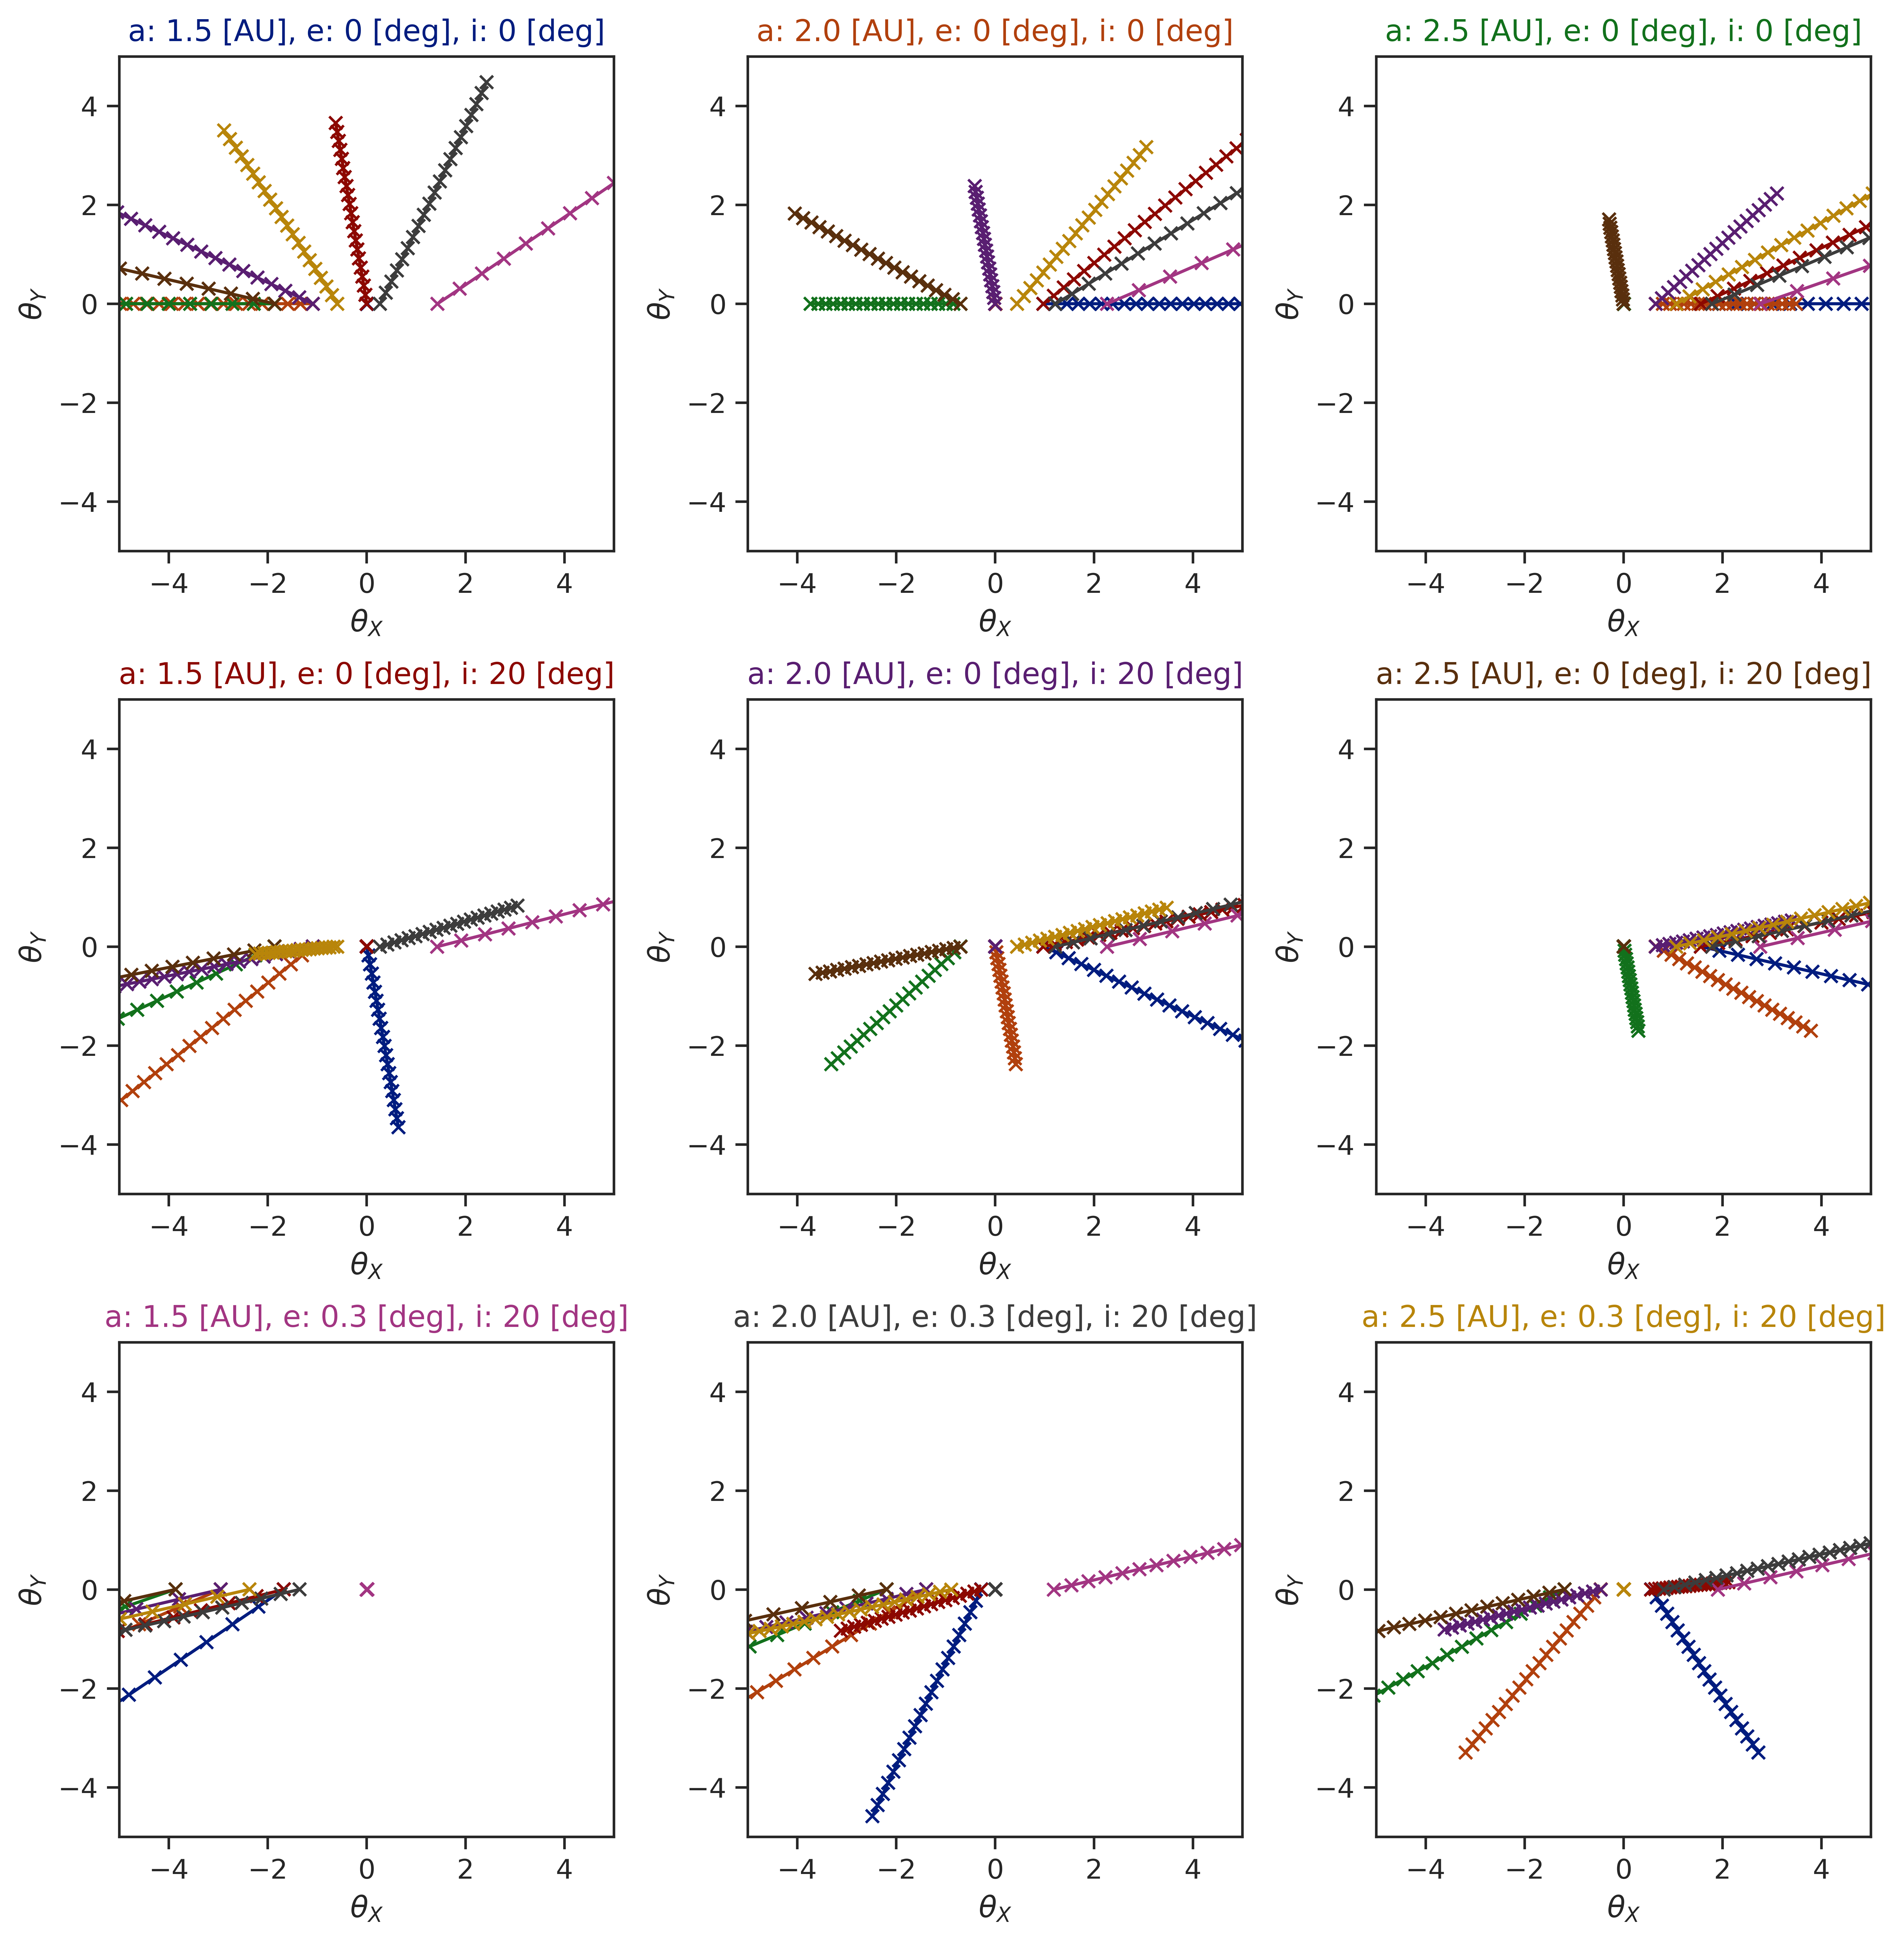

In [ ]:
fig, ax = plt.subplots(3, 3, dpi=DPI, figsize=(12,12))
ax = ax.flatten()
fig.tight_layout()

for i, k in enumerate(sim_orb.keys()):
    projected_obs = thor.rangeAndShift(
        ephs,
        ephs[ephs["designation"] == k]["RA_deg"].values[0],
        ephs[ephs["designation"] == k]["Dec_deg"].values[0],
        ephs[ephs["designation"] == k]["r_au"].values[0],
        ephs[ephs["designation"] == k][[
            "HEclObj_dX/dt_au_p_day",
            "HEclObj_dY/dt_au_p_day",
            "HEclObj_dZ/dt_au_p_day"]].values[0],
        new_epoch[0],
        numNights=num_nights,
        cellArea=50000000000, verbose=False)
    
    for j, kk in enumerate(sim_orb.keys()):
        ax[i].plot(projected_obs[projected_obs["designation"] == kk]["theta_x_deg"].values,
                   projected_obs[projected_obs["designation"] == kk]["theta_y_deg"].values,
                   color=sns.color_palette("dark").as_hex()[j],
                   marker='x',
                   markersize=5)
    ax[i].set_xlabel(r"$\theta_X$")
    ax[i].set_ylabel(r"$\theta_Y$")
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(-5, 5)
   # ax[i].set_yticks([-5, -, 0, 2, 4])
    ax[i].set_aspect("equal")
    ax[i].set_title(k, color=sns.color_palette("dark").as_hex()[i])
    
fig.subplots_adjust(wspace=0.2, hspace=0.3, bottom=0.1, top=0.9, left=0.1, right=0.9)
fig.savefig(os.path.join(SAVE_DIR, "algorithm_range_shift.{}".format(FORMAT)))

### Simulations

In [ ]:
RUN_DIR = "../../analysis/msst_4x4/run_3_new/"
DATABASE = "/epyc/projects/thor/data/msst_survey.db"
con = sql.connect(DATABASE)

In [ ]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [ ]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

In [ ]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59755""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59755""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2527774
2525712


In [ ]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [ ]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [ ]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

In [ ]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=DPI)
ax.set_xlabel(r"$\alpha$ [Deg]")
ax.set_ylabel(r"$\delta$ [Deg]")
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin(fields))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.set_aspect("equal")
ax.set_ylim(-20, 20)
ax.set_xlim(140, 200)
fig.savefig(os.path.join(SAVE_DIR, "simulations_footprint.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
observations = observations[observations["fieldId"].isin(fields)]
#observations.to_csv("../analysis/msst_4x4/observations.txt", sep=" ", index=False)

In [ ]:
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset="designation", inplace=True)
#orbits.to_csv("../analysis/msst_4x4/orbits.txt", sep=" ", index=False)

In [ ]:
allObjects_survey = thor.analyzeObservations(observations)

In [ ]:
average_object = thor.findAverageOrbits(observations, orbits, dValues=[2.9, 3])

In [ ]:
average_object

In [ ]:
no_noise = (~observations["designation"].isin(["NS"]))

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.scatter(*observations[no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.01, c="b")
ax.set_xlabel(r"$\alpha$ [Deg]")
ax.set_ylabel(r"$\delta$ [Deg]")
ax.scatter(*average_object[["RA_deg", "Dec_deg"]].values[0], s=2, c="r")
for ra, dec in average_object[["RA_deg", "Dec_deg"]].values[0:1]:
    ax.add_patch(patches.Circle([ra, dec], np.sqrt(10/np.pi), fill=False, lw=1, color="red"))
fig.savefig(os.path.join(SAVE_DIR, "algorithm1.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))
ax.scatter(*observations[no_noise][["RA_deg", "Dec_deg"]].values.T, s=0.01, c="b")
ax.set_xlabel(r"$\alpha$ [Deg]")
ax.set_ylabel(r"$\delta$ [Deg]")
ax.scatter(*average_object[["RA_deg", "Dec_deg"]].values.T, s=2, c="r")
ax.plot(*average_object[["RA_deg", "Dec_deg"]].values.T, lw=1, color="r")

for ra, dec in average_object[["RA_deg", "Dec_deg"]].values:
    ax.add_patch(patches.Circle([ra, dec], np.sqrt(10/np.pi), fill=False, lw=1, color="red"))
ax.set_aspect("equal")
fig.savefig(os.path.join(SAVE_DIR, "algorithm2.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
start_epoch = average_object["exp_mjd"] == average_object["exp_mjd"].min()

In [ ]:
projected_obs = thor.rangeAndShift(observations[no_noise], 
                                   average_object[start_epoch]["RA_deg"].values[0],
                                   average_object[start_epoch]["Dec_deg"].values[0],
                                   average_object[start_epoch]["r_au"].values[0],
                                   average_object[start_epoch][["HEclObj_dX/dt_au_p_day",
                                                                "HEclObj_dY/dt_au_p_day",
                                                                "HEclObj_dZ/dt_au_p_day"]].values[0],
                                   average_object[start_epoch]["exp_mjd"].values[0],
                                   cellArea=10,
                                   cellShape="circle",
                                   verbose=False)

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(7.5, 5.5))
ax.scatter(*projected_obs[["theta_x_deg", "theta_y_deg"]].values.T, s=0.1, c="b")
ax.set_xlabel(r"$\theta_X$ [Deg]")
ax.set_ylabel(r"$\theta_Y$ [Deg]")
ax.set_aspect("equal")
ax.scatter(0, 0, s=3, c="r")
ax.add_patch(patches.Rectangle((-0.5, -0.5), 1, 1, fill=False, lw=1, color="black"))

ax2 = fig.add_axes([0.9, 0.5, 0.5, 0.4])

fig.savefig(os.path.join(SAVE_DIR, "algorithm34.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
small = ((projected_obs["theta_x_deg"] > -0.5) & (projected_obs["theta_x_deg"] < 0.5) &
                          (projected_obs["theta_y_deg"] > -0.5) & (projected_obs["theta_y_deg"] < 0.5))

fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 5.5))

ax.scatter(*projected_obs[small][["theta_x_deg", "theta_y_deg"]].values.T, s=0.1, c="b")

for designation in projected_obs[(projected_obs["designation"].isin(allObjects_projection[allObjects_projection["findable"] == 1]["designation"].values)) 
                  & small]["designation"].unique():
    ax.plot(*projected_obs[small & (projected_obs["designation"] == designation)][["theta_x_deg", "theta_y_deg"]].values.T)

ax.set_xlabel(r"$\theta_X$ [Deg]")
ax.set_ylabel(r"$\theta_Y$ [Deg]")
ax.set_aspect("equal")
ax.scatter(0, 0, s=3, c="r")

In [ ]:
allObjects_projection, summary_projection = thor.analyzeProjections(projected_obs)

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 4))
ax.errorbar(allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_x/dt_median"].values,
            allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_y/dt_median"].values,
            yerr=allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_y/dt_sigma"].values,
            xerr=allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_x/dt_sigma"].values,
            fmt="o",
            ms=0.01,
            capsize=0.1,
            elinewidth=0.1,
            c="k", zorder=-1)
cm = ax.scatter(allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_x/dt_median"].values, 
                allObjects_projection[allObjects_projection["findable"] == 1]["dtheta_y/dt_median"].values,
                s=0.1,
                c=allObjects_projection[allObjects_projection["findable"] == 1]["r_au_median"].values,
                vmin=0,
                vmax=5.0,
                cmap="viridis")
ax.set_aspect("equal")

cbar_ax = fig.add_axes([0.9, 0.125, 0.03, 0.755])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"$r$ [AU]") 
             #format="%1i", 
             #orientation="horizontal")

# Add labels and text
cb.set_label("r [AU]")
ax.set_xlabel(r"Median $ d\theta_X / dt$ [Deg Per Day]")
ax.set_ylabel(r"Median $ d\theta_Y / dt$ [Deg Per Day]")
ax.set_xlim(-0.4, 0.6)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect("equal")
#ax.scatter(0, 0, s=2, c="r")
fig.savefig(os.path.join(SAVE_DIR, "projected_space_500.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
len(hungarias)

In [ ]:
hungarias = orbits[(orbits["a_au"] >= 1.78) 
       & (orbits["a_au"] <=  2.00) 
       & (orbits["i_deg"] >= 16) 
       & (orbits["i_deg"] <= 34) & (orbits["e"] < 0.18)]["designation"].values

In [ ]:
fig, ax = plt.subplots(1, 1, dpi=DPI, figsize=(5.5, 4))
ax.errorbar(allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_x/dt_median"].values,
            allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_y/dt_median"].values,
            yerr=allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_y/dt_sigma"].values,
            xerr=allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_x/dt_sigma"].values,
            fmt="o",
            ms=0.01,
            capsize=0.1,
            elinewidth=0.1,
            c="k", zorder=-1)
cm = ax.scatter(allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_x/dt_median"].values, 
                allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["dtheta_y/dt_median"].values,
                s=0.1,
                c=allObjects_projection[(allObjects_projection["findable"] == 1) & (allObjects_projection["designation"].isin(hungarias))]["r_au_median"].values,
                vmin=0,
                vmax=5.0,
                cmap="viridis")
ax.set_aspect("equal")

cbar_ax = fig.add_axes([0.9, 0.125, 0.03, 0.755])
fig.colorbar(cm, 
             cax=cbar_ax, 
             label=r"$r$ [AU]") 
             #format="%1i", 
             #orientation="horizontal")

# Add labels and text
cb.set_label("r [AU]")
ax.set_xlabel(r"Median $ d\theta_X / dt$ [Deg Per Day]")
ax.set_ylabel(r"Median $ d\theta_Y / dt$ [Deg Per Day]")
ax.set_xlim(-0.4, 0.6)
ax.set_ylim(-0.4, 0.4)
ax.set_aspect("equal")
#ax.scatter(0, 0, s=2, c="r")
fig.savefig(os.path.join(SAVE_DIR, "projected_space_hungarias_500.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]")
ax.set_ylabel("Dec [Degrees]")
for xx, yy in zip(survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min()) & (survey["fieldId"].isin([405]))]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2- 0.01, yy-yField/2 -0.01), xField+0.01, yField+0.01, fill=False, lw=0.5, color="k"))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["fieldId"].isin([405]))]["Dec_deg"].values,
           s=0.1,
           c="b")
ax.scatter(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, s=1, c="r", 
           label="Test Orbit")
ax.legend()
ax.set_aspect("equal")
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(survey[survey["fieldId"].isin([405])]["fieldDec_deg"].values, *xlim, lw=0.5, color="r")
ax.vlines(survey[survey["fieldId"].isin([405])]["fieldRA_deg"].values, *ylim, lw=0.5, color="r")
ax.set_xlim(xlim)
ax.set_ylim(ylim)

In [ ]:
from thor import Config

def plotCompleteness(allObjects, orbits, testOrbits=None, columnMapping=Config.columnMapping):
    
    findable = allObjects[allObjects["findable"] == 1]["designation"].values
    found = allObjects[allObjects["found"] == 1]["designation"].values
    missed = allObjects[(allObjects["found"] == 0) & (allObjects_survey["findable"] == 1)]["designation"].values

    BINS = 50
    RANGE_AI = [[0.5, 5.5], [0, 50]]
    RANGE_AE = [RANGE_AI[0], [0, 1]]
    LEVELS = [10, 100, 1000]

    # Calculate 2D binned statistics:
    # X_ai: orbital distribution in a and i
    # N_ai : number of objects discoverable in same bins as X_ai
    X_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)

    N_ai = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,    
        statistic="count",
        range=RANGE_AI,
        bins=BINS)
    
    stat_ai = X_ai.statistic.T / N_ai.statistic.T * 100.0
    counts_ai = N_ai.statistic.T
    stat_ai=np.ma.masked_where(stat_ai==np.NaN, stat_ai)
    
    # Calculate 2D binned statistics:
    # X_ae: orbital distribution in a and e
    # N_ae : number of objects discoverable in same bins as X_ai
    X_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(found)]["a_au"].values,
        orbits[orbits["designation"].isin(found)]["e"].values,
        orbits[orbits["designation"].isin(found)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    N_ae = binned_statistic_2d(
        orbits[orbits["designation"].isin(findable)]["a_au"].values,
        orbits[orbits["designation"].isin(findable)]["e"].values,
        orbits[orbits["designation"].isin(findable)]["i_deg"].values,    
        statistic="count",
        range=RANGE_AE,
        bins=BINS)

    stat_ae = X_ae.statistic.T / N_ae.statistic.T * 100.0
    counts_ae = N_ae.statistic.T
    stat_ae=np.ma.masked_where(stat_ae==np.NaN, stat_ae)
    
    # Make the figure
    fig, ax = plt.subplots(2, 1, dpi=DPI, figsize=(5.5, 9))
    fig.subplots_adjust(
        # the left side of the subplots of the figure
        left=0.15,  
        # the right side of the subplots of the figure
        right=1.0,
        # the bottom of the subplots of the figure
        bottom=0.2,
        # the top of the subplots of the figure
        top=0.95,
        # the amount of width reserved for space between subplots,
        # expressed as a fraction of the average axis width
        wspace=0.01,   
        # the amount of height reserved for space between subplots,
        # expressed as a fraction of the average axis height
        hspace=0.2)   
                       
    
    # Set NaN values in stat to be white 
    cmap = matplotlib.cm.viridis
    cmap.set_bad('w', np.NaN)

    # Plot a-i completeness
    cm1 = ax[0].imshow(stat_ai, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   extent=[X_ai.x_edge[0], X_ai.x_edge[-1], X_ai.y_edge[0], X_ai.y_edge[-1]])

    # Add contours
    cs1 = ax[0].contour(counts_ai, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ai.x_edge[0], N_ai.x_edge[-1], N_ai.y_edge[0], N_ai.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs1, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[0].set_ylabel("Inclination ($i$) [Deg]")
    ax[0].set_xlabel("Semi-Major Axis ($a$) [AU]")
    ax[0].set_xlim(*RANGE_AI[0])
    ax[0].set_ylim(*RANGE_AI[1])

    # Plot a-e completeness
    cm2 = ax[1].imshow(stat_ae, 
                   origin="lower", 
                   cmap=cmap,
                   interpolation='none',
                   aspect="auto",
                   #norm=colors.LogNorm(),
                   extent=[X_ae.x_edge[0], X_ae.x_edge[-1], X_ae.y_edge[0], X_ae.y_edge[-1]])
    
    # Plot test orbits 
    if type(testOrbits) == pd.DataFrame:
        # If test orbits exist in known orbits, plot them
        test_orbits_in_known = orbits[orbits[columnMapping["name"]].isin(testOrbits[columnMapping["name"]].values)]
        if len(test_orbits_in_known) != 0:
            ax[0].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["i_deg"]]].values.T, 
                       s=4, 
                       c="red",
                       label="Test Orbits",
                       zorder=10)
            
            ax[1].scatter(*test_orbits_in_known[[columnMapping["a_au"], columnMapping["e"]]].values.T, 
                       s=4, 
                       c="red",
                       label="Test Orbits",
                       zorder=10)

    # Add contours
    cs2 = ax[1].contour(counts_ae, 
                    LEVELS, 
                    origin="lower", 
                    extent=[N_ae.x_edge[0], N_ae.x_edge[-1], N_ae.y_edge[0], N_ae.y_edge[-1]],
                    colors="red",
                    linewidths=1)
    plt.clabel(cs2, inline=1, fontsize=4, fmt="%1.0f")

    # Add labels
    ax[1].set_ylabel("Eccentricity ($e$)")
    ax[1].set_xlabel("Semi-Major Axis ($a$) [AU]")
    ax[1].set_xlim(*RANGE_AE[0])
    ax[1].set_ylim(*RANGE_AE[1])
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.15, 0.1, 0.65, 0.02])
    fig.colorbar(cm2, 
                 cax=cbar_ax, 
                 label="Completeness [%]", 
                 format="%1i", 
                 orientation="horizontal")
     
    return fig, ax 

In [ ]:
fig, ax = plotCompleteness(allObjects_survey, 
                 known_orbits, 
                 testOrbits=known_orbits[known_orbits["designation"].isin(test_orbits)])
ax[0].text(0.6, 47, "a)")
ax[1].text(0.6, 0.94, "b)")
fig.savefig(os.path.join(SAVE_DIR, "simulations_a_ie_completeness.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
orbit_id = 1
projected_obs = pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/projected_obs.txt".format(orbit_id)), sep=" ", index_col=False)
allObjects_projection = pd.read_csv(os.path.join(RUN_DIR, "orbit_{:04d}/allObjects.txt".format(orbit_id)), sep=" ", index_col=False)

In [ ]:
fig, ax = plt.subplots( )

In [ ]:
fig, ax = thor.plotProjectionVelocitiesFindable(allObjects_projection)
ax.scatter(*allObjects_projection[allObjects_projection["designation"].isin(test_orbits)][["dtheta_x/dt_median", "dtheta_y/dt_median"]].values.T, 
           c="r", 
           s=2)

### ZTF 

In [ ]:
columnMapping = {        
        
        # Observation ID
        "obs_id" : "obs_id",
        
        # Exposure time
        "exp_mjd" : "exp_mjd",
        
        # Visit ID
        "visit_id" : "visit_id",
        
        # Field ID
        "field_id" : "field",
        
        # Field RA in degrees
        "field_RA_deg" : "fieldRA_deg",
        
        # Field Dec in degrees
        "field_Dec_deg" : "fieldDec_deg",
        
        # Night number
        "night": "nid",
        
        # RA in degrees
        "RA_deg" : "ra",
        
        # Dec in degrees
        "Dec_deg" : "decl",
        
        # Observer's x coordinate in AU
        "obs_x_au" : "HEclObsy_X_au",
        
        # Observer's y coordinate in AU
        "obs_y_au" : "HEclObsy_Y_au",
        
        # Observer's z coordinate in AU
        "obs_z_au" : "HEclObsy_Z_au",
        
        # Magnitude (UNUSED)
        "mag" : "magpsf",
        
        ### Truth Parameters
        
        # Object name
        "name" : "designation",
        
        # Observer-object distance in AU
        "Delta_au" : "Delta_au",
        
        # Sun-object distance in AU (heliocentric distance)
        "r_au" : "r_au",
        
        # Object's x coordinate in AU
        "obj_x_au" : "HEclObj_X_au",
        
        # Object's y coordinate in AU
        "obj_y_au" : "HEclObj_Y_au",
        
        # Object's z coordinate in AU
        "obj_z_au" : "HEclObj_Z_au",
        
        # Object's x velocity in AU per day
        "obj_dx/dt_au_p_day" : "HEclObj_dX/dt_au_p_day",
        
        # Object's y velocity in AU per day
        "obj_dy/dt_au_p_day" : "HEclObj_dY/dt_au_p_day",
        
        # Object's z velocity in AU per day
        "obj_dz/dt_au_p_day" : "HEclObj_dZ/dt_au_p_day",
        
        # Semi-major axis
        "a_au" : "a_au",
        
        # Inclination
        "i_deg" : "i_deg",
        
        # Eccentricity
        "e" : "e",
    }

In [ ]:
RUN_DIR = "../../analysis/ztf/run_10/"

In [ ]:
allObjects_survey = pd.read_csv(os.path.join(RUN_DIR, "allObjects_survey.txt"), sep=" ", index_col=False)
summary_survey = pd.read_csv(os.path.join(RUN_DIR, "summary_survey.txt"), sep=" ", index_col=False)
summary_orbits = pd.read_csv(os.path.join(RUN_DIR, "summary_orbits.txt"), sep=" ", index_col=False)
test_orbits_survey = pd.read_csv(os.path.join(RUN_DIR, "orbits.txt"), sep=" ", index_col=False)

known_orbits = pd.read_sql("SELECT * FROM mpcOrbitCat", con)
known_orbits = known_orbits[known_orbits["designation"].isin(allObjects_survey["designation"].values)]

In [ ]:
findable = allObjects_survey[allObjects_survey["findable"] == 1]["designation"].values
found = allObjects_survey[allObjects_survey["found"] == 1]["designation"].values
missed = allObjects_survey[(allObjects_survey["found"] == 0) & (allObjects_survey["findable"] == 1) ]["designation"].values
test_orbits = test_orbits_survey["designation"].values

In [ ]:
fig, ax = plotCompleteness(allObjects_survey, 
                 known_orbits, 
                 testOrbits=known_orbits[known_orbits["designation"].isin(test_orbits)],
                 columnMapping=columnMapping)
fig.savefig(os.path.join(SAVE_DIR, "ztf_a_ie_completeness.{}".format(FORMAT)),
            bbox_inches='tight')

In [ ]:
simulated_ephemeris = pd.read_csv("../../analysis/ztf/known_object_observations_nid_610_624.eph", sep=" ", index_col=False, low_memory=False)
known_orbits = pd.read_csv("../../analysis/ztf/known_object_observations_nid_610_624.orb", sep=" ", index_col=False, low_memory=False)

#observations = pd.read_csv("../analysis/ztf/known_object_observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)
observations = pd.read_csv("../../analysis/ztf/observations_nid_610_624.txt", sep=" ", index_col=False, low_memory=False)

observations.sort_values(by="mjd", inplace=True)
#observations.drop(index=observations[observations["designation"].isna()].index, inplace=True)
observations.loc[observations["designation"].isna(), "designation"] = -1